In [1]:
%reload_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from datasets import DatasetEEG, DatasetEEGTorch
import torch
import torch.nn as nn
import numpy as np

from utils import plot_training_metrics, count_model_parameters, train_model
from dataset_filters import normalize_signals, crop_signals
from matplotlib import pyplot as plt


In questo esempio confronto i modelli per l'encoding dei segnali. Poi la classificazione viene effettuata a partire dai vettori encoded.

Preparo i dataset

In [2]:
# Carico i dataset per il training e il test
dataset_bci = DatasetEEG.load('DatasetBCI/Dataset_01_Training.dataset')
dataset_bci_test = DatasetEEG.load('DatasetBCI/Dataset_01_Test.dataset')

# Li normalizzo e croppo
normalize_signals(dataset_bci)
normalize_signals(dataset_bci_test)

crop_signals(dataset_bci, t_min=0.5, t_max=2.5)
crop_signals(dataset_bci_test, t_min=0.5, t_max=2.5)

# Mostro le caratteristiche dei due dataset
print(dataset_bci)
print(dataset_bci_test)

# Altre caratteristiche dei dati che serviranno successivamente
fs = 250
channels = 22
num_timepoints = dataset_bci.num_timepoints


num_trials               :  288
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250

num_trials               :  288
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250



In [3]:
dataset_training, dataset_validation = dataset_bci.split_dataset(validation_size=0.2)

print(dataset_training)
print(dataset_validation)

dataset_training_pytorch = DatasetEEGTorch(dataset_training)
dataset_validation_pytorch = DatasetEEGTorch(dataset_validation)
dataset_test_pytorch = DatasetEEGTorch(dataset_bci_test)

num_trials               :  230
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250

num_trials               :  58
num_channels             :  22
num_timepoints           :  500
labels_type              :  int
subject                  :  1
fs                       :  250



In [4]:
# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_training_pytorch.to_device(device)
dataset_validation_pytorch.to_device(device)
dataset_test_pytorch.to_device(device)


cuda


/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# Creo i dataloader
batch_size = 32
dataloader_training = DataLoader(dataset_training_pytorch, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(dataset_validation_pytorch, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test_pytorch, batch_size=batch_size, shuffle=False)

## VAE Customizzabile
Il primo modello è una VAE che può essere customizzata fornendo un encoder e un decoder. 
Per l'encoder uso EEGNet, mentre per il decoder bisogna invertire accuratamente i livelli (convoluzioni trasposte al posto delle convoluzioni, upsampling al posto di avgpool) e alla fine viene inserito un ulteriore livello Conv2d per correggere la dimensione dell'output e riportarla allo stesso numero di punti temporali. Inoltre è importante sapere la dimensione dei tensori poco prima del livello latente, in quanto questa è il punto di partenza per costruire il primo livello del decoder. Per facilitare il compito genere un tensore dummy di dimensione nota e lo uso per vedere la dimensione del vettore poco prima che venga encoded.

In [6]:
from models.VAEs import VAE
from models.custom_blocks import Conv2dMaxNorm

latent_dim = 1024
F1, F2 = 16, 32

# Encoder uguale a EEGNet
encoder = nn.Sequential(
        nn.Conv2d(1, F1, kernel_size=(1, 128), padding='same', bias=False), # First temporal convolution
        nn.BatchNorm2d(F1),
        Conv2dMaxNorm(F1, F2, kernel_size=(channels, 1), bias=False, groups=F1, max_norm_val=1), # Depthwise convolution
        nn.BatchNorm2d(F2),
        nn.ELU(),
        nn.AvgPool2d(kernel_size=(1,4)),
        nn.Dropout(0.5),
        nn.Conv2d(F2, F2, kernel_size=(1, 16), bias=False, groups=F2),  # Separable = Depthwise + Pointwise
        nn.Conv2d(F2, F2, kernel_size=(1, 1), bias=False),              # Separable = Depthwise + Pointwise
        nn.BatchNorm2d(F2),
        nn.ELU(),
        nn.AvgPool2d(kernel_size=(1,8)),
        nn.Dropout(0.5),
)
    
dummy_input, _ = dataset_training_pytorch[0:1]
dummy_input = dummy_input.cpu()

# Applico l'encoder e vedo la dimensione dei tensori poco prima del livello latente
dummy_encoded = encoder(dummy_input)
print(dummy_encoded.shape)


decoder = nn.Sequential(
        nn.Linear(latent_dim, 13 * 32),
        nn.Unflatten(1, (32, 1, 13)), 
        # Upsampling
        nn.Upsample(scale_factor=(1,8), mode='bilinear'),
        # Convoluzione temporale finale depthwise separable
        nn.ConvTranspose2d(F2, F2, kernel_size=(1, 16), bias=False, groups=F2),  # Separable = Depthwise + Pointwise
        nn.ConvTranspose2d(F2, F2, kernel_size=(1, 1), bias=False),              # Separable = Depthwise + Pointwise
        nn.BatchNorm2d(F2),
        nn.ELU(),
        nn.Dropout(0.5),
        # Upsampling
        nn.Upsample(scale_factor=(1,4), mode='bilinear'),
        # Convoluzione canali
        nn.ConvTranspose2d(F2, F2, kernel_size=(channels, 1), bias=False, groups=F2), # Depthwise convolution
        nn.BatchNorm2d(F2),
        nn.ELU(),
        nn.Dropout(0.5),
        # Ultima convoluzione temporale
        nn.ConvTranspose2d(F2, 1, kernel_size=(1, 128), padding=(0,64), bias=False), # First temporal convolution
        # Convoluzione per correggere la dimensione
        nn.ConvTranspose2d(1, 1, kernel_size=(1, 26), bias=False), # First temporal convolution
        )

# Prendo un vettore di "z" vuoto e lo passo attraverso il decoder
dummy_z = torch.zeros((1, latent_dim))
dummy_decoded = decoder(dummy_z)
print(dummy_decoded.shape)

# Creo il modello VAE
model = VAE(encoder, decoder, latent_dim)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')


torch.Size([1, 32, 1, 13])
torch.Size([1, 1, 22, 500])
Il modello ha 437338 parametri


/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


100%|██████████| 500/500 [01:00<00:00,  8.23it/s, reconstruction_loss=0.447, kl_loss=0.043, loss=0.49]  


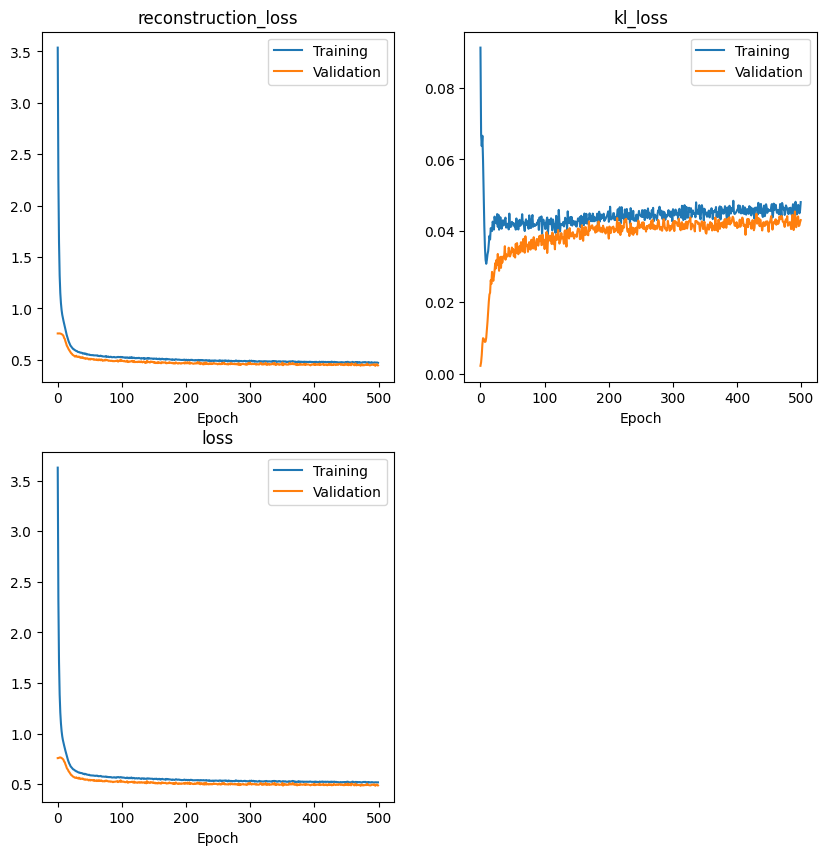

In [7]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training,
                      dataloader_validation=dataloader_validation, epochs=500)

# Plot risultati del training
plot_training_metrics(metrics)

Visualizzo la bonta della ricostruzione dei segnali su uno dei trial di training

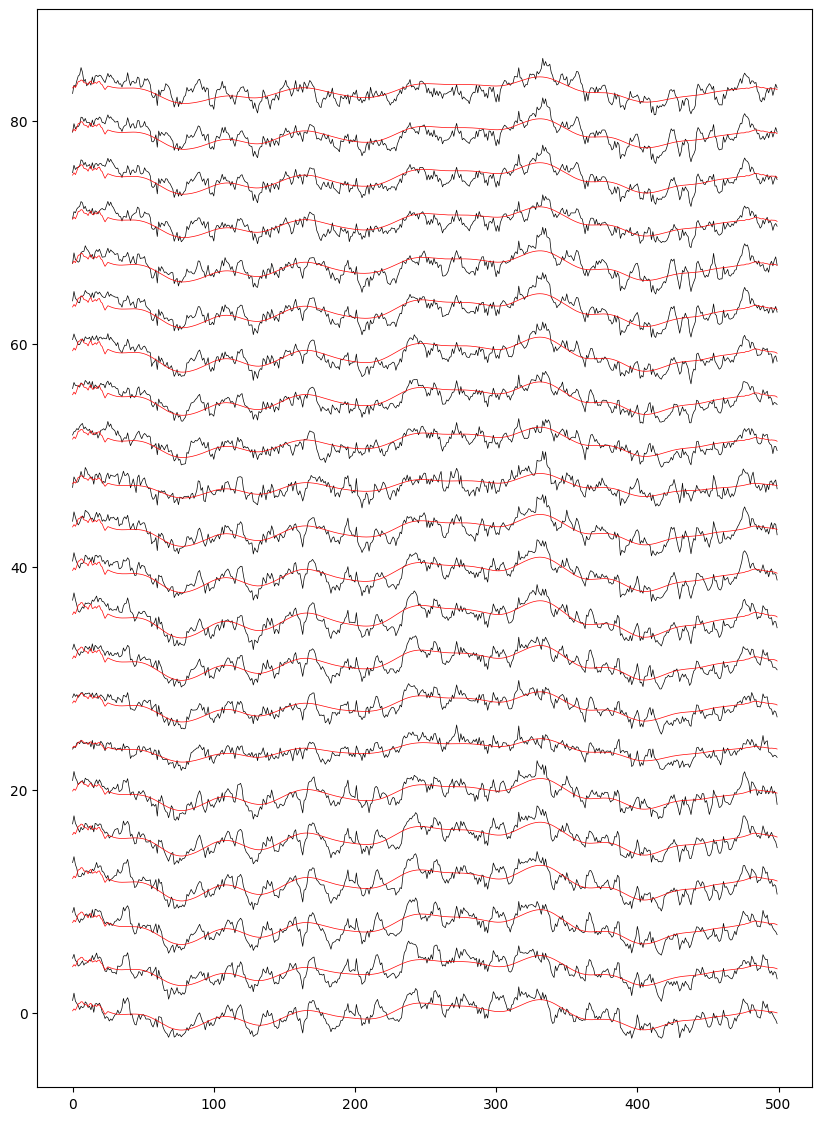

In [8]:
# Prendo il trial 0 e lo passo nella VAE per ottenerne la ricostruzione
x, _ = dataset_training_pytorch[0]
trial_train = x.view(1, 1, 22, num_timepoints).to(device)
decoded, _, _ = model(trial_train)

# Visualizzo tutti i canali uno sotto l'altro
std = torch.std(trial_train)

plt.figure(figsize=(10,14))
for i in range(channels):

    y_shift = 4 * std * i

    plt.plot(trial_train[0,0,i,:].cpu() + y_shift.cpu(), color='k', linewidth=0.5)
    plt.plot(decoded[0,0,i,:].detach().cpu() + y_shift.cpu(), color='r', linewidth=0.5)



Per valutare l'accuratezza fitto un Support Vector Classifier (SVC) sulle rappresentazioni encoded della rete nel training set e poi testo il classificatore sul test set. Notare che a ogni esecuzione il risultato è diverso, poiché le rappresentazioni latenti "z" vengono samplate casualmente. Per ottenere un risultato stabile è possibile sostituire "z" con il vettore delle medie delle gaussiane "mu"

In [9]:
model.eval()

# Training set
encoded_train = np.zeros((0, latent_dim))
labels_train = np.zeros(0)

for batch in dataloader_training:

    x, label =  batch

    _, mu, logvar = model.forward(x)
    z = model.reparameterize(mu, logvar)

    encoded_train = np.concatenate((encoded_train, z.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, label.cpu().detach().numpy()))

# Test set
encoded_test = np.zeros((0, latent_dim))
labels_test  = np.zeros(0)

for batch in dataloader_test:

    x, label =  batch

    _, mu, logvar = model.forward(x)
    z = model.reparameterize(mu, logvar)

    encoded_test = np.concatenate((encoded_test, z.cpu().detach().numpy()), axis=0)
    labels_test = np.concatenate((labels_test, label.cpu().detach().numpy()))

# Inizializzo il modello SVC
from sklearn.svm import SVC

model_svc = SVC()

# Fit del modello e calcolo accuratezza
model_svc.fit(encoded_train, labels_train)
accuracy = model_svc.score(encoded_train, labels_train)

print(f'Training accuracy = {accuracy*100:.2f}%')

# Ripeto sul testing set
accuracy = model_svc.score(encoded_test, labels_test)

print(f'Test accuracy = {accuracy*100:.2f}%')


Training accuracy = 100.00%
Test accuracy = 30.56%


## InfoNCE model
Creo un encoder simile a quello di Cebra. Nel mio caso non faccio una divisione in finestre temporali e considero i trail completi come un unico sample. Le label che definiscono la somiglianza tra sample sono proprio le label usate per la classificazione. 

Per poter far funzionare questo tipo di modelli è necessario creare dei dataset nuovi (di quelli pytorch) in quanto a ogni richiesta di un elemento del dataset "x" non deve essere restituito solo lui, ma anche un altro trial con la stessa label "y_p" e 10 trial con label diverse "y_n".

In questo caso non creo un validation set, perché conterrebbe troppi pochi elementi per garantire un corretto funzionamento.

In [10]:
from datasets import DatasetEEGTorchCebra

# Creo i dataset
dataset_training_cebra = DatasetEEGTorchCebra(dataset_bci)
dataset_test_cebra = DatasetEEGTorchCebra(dataset_bci_test)

# Sposto su GPU
dataset_training_cebra.to_device(device)
dataset_test_cebra.to_device(device)

# Creo i dataloader
batch_size = 32
dataloader_training_cebra = DataLoader(dataset_training_cebra, batch_size=batch_size, shuffle=False)
dataloader_test_cebra = DataLoader(dataset_test_cebra, batch_size=batch_size, shuffle=False)



Il modello da utilizzare per l'encoding di ogni sample è customizzabile e definito dall'utente. In questo caso uso ShallowNet e prendo solo 3 dimensioni latenti in modo da rendere semplice la visualizzazione.

Il parametro "normalize_latents" permette di attivare la normalizzazione su ipersfera fatta da Cebra e fa sì che la distanza tra vettori encoded sia data dal prodotto scalare, altrimenti è la distanza euclidea.

In [11]:
from models.EncoderInfoNCE import EncoderInfoNCE

F1, F2 = 8, 16
latent_dim = 3


filters = 32
layers = nn.Sequential(
        nn.Conv2d(1, filters, kernel_size=(1, 13)),
        nn.Conv2d(filters, filters, kernel_size=(channels, 1), bias=False),
        nn.BatchNorm2d(filters),
        nn.MaxPool2d(kernel_size=(1, 35), stride=(1, 7)),
        nn.Dropout(0.5),
        nn.Flatten(),
        nn.LazyLinear(latent_dim)
)


model = EncoderInfoNCE(layers=layers, temperature=1, normalize_latents=True)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')


Il modello ha 23040 parametri


  0%|          | 1/200 [00:01<03:25,  1.03s/it, loss=0.0723]

100%|██████████| 200/200 [02:49<00:00,  1.18it/s, loss=0.0439]


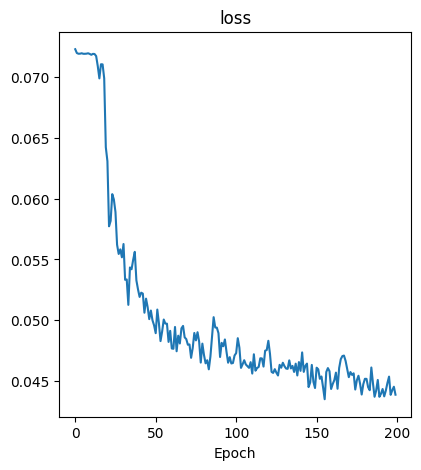

In [12]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training_cebra, epochs=200)

# Plot risultati del training
plot_training_metrics(metrics)

Visualizzo le rappresentazioni dei vari trial sulla sfera e le coloro in base alla label corrispondente. 

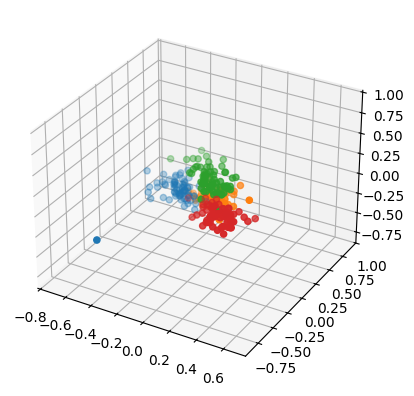

In [13]:
# Ottengo le rappresentazioni encoded del training set
model.eval()

encoded_train = np.zeros((0, latent_dim))
labels_train = np.zeros(0)

for batch in dataloader_training_cebra:

    x, y_pos, y_neg, label = batch

    f_x, _, _ = model.forward(x, y_pos, y_neg)

    encoded_train = np.concatenate((encoded_train, f_x.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, label.cpu().detach().numpy()))

# Visualizzo, separandole per label
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for l in range(4):
    mask = labels_train == l
    ax.scatter(encoded_train[mask,0], encoded_train[mask,1], encoded_train[mask,2])


Ripeto l'encoding sul test set e utilizzo una SVC per calcolare le accuratezze

In [14]:
# Test set
encoded_test = np.zeros((0, latent_dim))
labels_test  = np.zeros(0)

for batch in dataloader_test_cebra:

    x, y_pos, y_neg, label = batch

    f_x, _, _ = model.forward(x, y_pos, y_neg)

    encoded_test = np.concatenate((encoded_test, f_x.cpu().detach().numpy()), axis=0)
    labels_test = np.concatenate((labels_test, label.cpu().detach().numpy()))

# Inizializzo il modello SVC
from sklearn.svm import SVC

model_svc = SVC()

# Fit del modello e calcolo accuratezza
model_svc.fit(encoded_train, labels_train)
accuracy = model_svc.score(encoded_train, labels_train)

print(f'Training accuracy = {accuracy*100:.2f}%')

# Ripeto sul testing set
accuracy = model_svc.score(encoded_test, labels_test)

print(f'Test accuracy = {accuracy*100:.2f}%')


Training accuracy = 95.49%
Test accuracy = 60.76%


## VAE + Classificatore
Il precedente modello performa molto meglio di una VAE perché l'informazione sulle label viene usata anche durante il training dell'encoder (e non soltanto alla fine con la classificazione della SVC). Per questo è possibile unire la VAE a un classificatore, che prende in input le rappresentazioni latenti "z", in modo da spingere la VAE ad apprendere rappresentazioni più significative per il compito di classificazione

In [15]:
from models.VAEs import VAEClassifier
from models.custom_blocks import Conv2dMaxNorm

latent_dim = 128
filters = 32

encoder = nn.Sequential(
        Conv2dMaxNorm(1, filters, kernel_size=(1, 13)),
        Conv2dMaxNorm(filters, filters, kernel_size=(channels, 1), bias=False),
        nn.BatchNorm2d(filters),
        nn.MaxPool2d(kernel_size=(1, 35), stride=(1, 7)),
        nn.Dropout(0.5)
)

decoder = nn.Sequential(
        nn.Linear(latent_dim, 65 * 32),
        nn.Unflatten(1, (32, 1, 65)), 
        nn.ConvTranspose2d(filters, filters, kernel_size=(1, 13)),
        nn.ConvTranspose2d(filters, filters, kernel_size=(channels, 1), bias=False),
        nn.BatchNorm2d(filters),
        nn.ConvTranspose2d(filters, 1, kernel_size=(1, 44), stride=(1, 6)),
        nn.Dropout(0.5)
)

classifier = nn.Sequential(
        nn.Linear(latent_dim, 32),
        nn.ELU(),
        nn.Dropout(0.7),
        nn.Linear(32, 4)
)

# Creo il modello VAE
model = VAEClassifier(encoder, decoder, classifier, latent_dim, num_classes=4)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')


Il modello ha 332965 parametri


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:02<00:00,  8.05it/s, reconstruction_loss=0.623, kl_loss=0.14, classifier_loss=1.95, loss=2.71] 


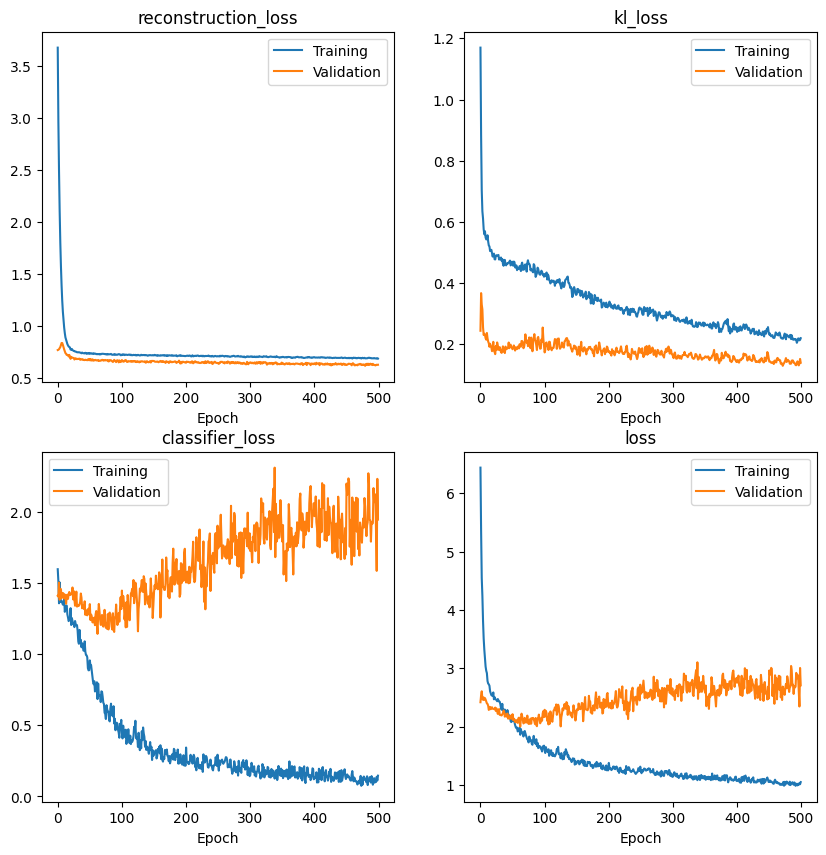

In [16]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training,
                      dataloader_validation=dataloader_validation, epochs=500)

# Plot risultati del training
plot_training_metrics(metrics)

Testo il modello sul test set

In [17]:
# Setto il modello in modalità eval (non training)
model.eval()

# Inizializzo per accumulare poi in ogni batch
accuracy = 0

# Ciclo sul test set
for i, batch in enumerate(dataloader_test):

    x, y = batch
    y_pred = model.predict(x)

    # Calcolo l'accuratezza
    accuracy += torch.sum(y_pred == y).item()

accuracy /= len(dataloader_test.dataset)

print(f'Accuratezza sul test set = {accuracy:.4f}')


Accuratezza sul test set = 0.5903


Confronto il risultato del classificatore con quello di una SVC addestrata sulle rappresentazioni latenti, per controllare che l'aggiunta del classificatore le abbia modificate rispetto al caso precedente

In [18]:
# Training set
encoded_train = np.zeros((0, latent_dim))
labels_train = np.zeros(0)

for batch in dataloader_training:

    x, label =  batch

    _, mu, logvar, _ = model.forward(x)
    z = model.reparameterize(mu, logvar)

    encoded_train = np.concatenate((encoded_train, z.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, label.cpu().detach().numpy()))

# Test set
encoded_test = np.zeros((0, latent_dim))
labels_test  = np.zeros(0)

for batch in dataloader_test:

    x, label =  batch

    _, mu, logvar, _ = model.forward(x)
    z = model.reparameterize(mu, logvar)

    encoded_test = np.concatenate((encoded_test, z.cpu().detach().numpy()), axis=0)
    labels_test = np.concatenate((labels_test, label.cpu().detach().numpy()))

# Inizializzo il modello SVC
from sklearn.svm import SVC

model_svc = SVC()

# Fit del modello e calcolo accuratezza
model_svc.fit(encoded_train, labels_train)
accuracy = model_svc.score(encoded_train, labels_train)

print(f'Training accuracy = {accuracy*100:.2f}%')

# Ripeto sul testing set
accuracy = model_svc.score(encoded_test, labels_test)

print(f'Test accuracy = {accuracy*100:.2f}%')


Training accuracy = 100.00%
Test accuracy = 59.03%


## InfoNCE con pesi
Una mia modifica di InfoNCE che non richiede la generazione di sample positivi e negativi, ma permette di assegnare una distanza tra le label. Inoltre è possibile utilizzare i dataset pytorch standard per questo modello

In [65]:
from models.EncoderInfoNCE import EncoderInfoNCEWeighted


F1, F2 = 8, 16
latent_dim = 3


filters = 32
layers = nn.Sequential(
        nn.Conv2d(1, filters, kernel_size=(1, 13)),
        nn.Conv2d(filters, filters, kernel_size=(channels, 1), bias=False),
        nn.BatchNorm2d(filters),
        nn.MaxPool2d(kernel_size=(1, 35), stride=(1, 7)),
        nn.Dropout(0.5),
        nn.Flatten(),
        nn.LazyLinear(latent_dim)
)

model = EncoderInfoNCEWeighted(layers=layers, temperature=0.1, normalize_latents=True)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')

Il modello ha 23040 parametri


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s, loss=0.0252]


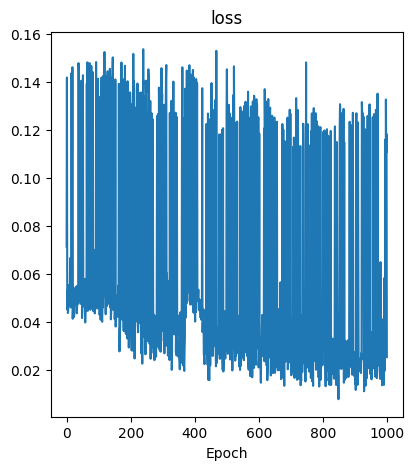

In [66]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training, epochs=1000)

# Plot risultati del training
plot_training_metrics(metrics)

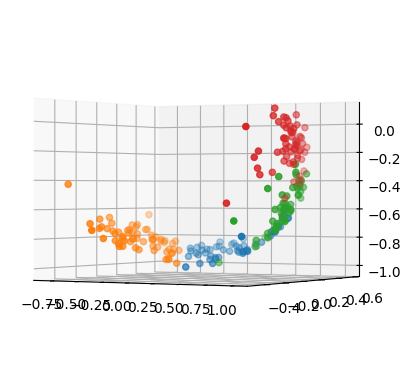

In [71]:
# Ottengo le rappresentazioni encoded del training set
model.eval()

encoded_train = np.zeros((0, latent_dim))
labels_train = np.zeros(0)

for batch in dataloader_training:

    x, label = batch

    f_x, f_y = model.forward(x)
    f = torch.cat((f_x.view(1, latent_dim), f_y), dim=0)
    
    encoded_train = np.concatenate((encoded_train, f.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, label.cpu().detach().numpy()))

# Visualizzo, separandole per label
fig = plt.figure()
ax = fig.add_subplot(projection='3d', elev=0)

for l in range(4):
    mask = labels_train == l
    ax.scatter(encoded_train[mask,0], encoded_train[mask,1], encoded_train[mask,2])


In [72]:
# Test set
encoded_test = np.zeros((0, latent_dim))
labels_test  = np.zeros(0)

for batch in dataloader_test:

    x, label = batch

    f_x, f_y = model.forward(x)
    f = torch.cat((f_x.view(1, latent_dim), f_y), dim=0)
    
    encoded_test = np.concatenate((encoded_test, f.cpu().detach().numpy()), axis=0)
    labels_test = np.concatenate((labels_test, label.cpu().detach().numpy()))

# Inizializzo il modello SVC
from sklearn.svm import SVC

model_svc = SVC()

# Fit del modello e calcolo accuratezza
model_svc.fit(encoded_train, labels_train)
accuracy = model_svc.score(encoded_train, labels_train)

print(f'Training accuracy = {accuracy*100:.2f}%')

# Ripeto sul testing set
accuracy = model_svc.score(encoded_test, labels_test)

print(f'Test accuracy = {accuracy*100:.2f}%')


Training accuracy = 89.13%
Test accuracy = 56.25%
